In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import random
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

In [2]:
# Set random seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)

### Pre-processing and selecting the metric

In [3]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Split the training data into training and validation sets
x_train, x_val = train_test_split(x_train, test_size=0.1, random_state=42)

x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

### Train your initial model

In [4]:
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam

def create_autoencoder(latent_dim=(4, 4, 32), input_shape=(28, 28, 1)):
    class Autoencoder(Model):
        def __init__(self, latent_dim, shape):
            super(Autoencoder, self).__init__()
            self.latent_dim = latent_dim
            self.shape = shape
            # Encoder
            self.encoder = tf.keras.Sequential([
                layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
                layers.MaxPooling2D((2, 2), padding='same'),
                layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
                layers.MaxPooling2D((2, 2), padding='same'),
                layers.Conv2D(latent_dim[2], (3, 3), activation='relu', padding='same'),
                layers.MaxPooling2D((2, 2), padding='same')
            ])
            # Decoder
            self.decoder = tf.keras.Sequential([
                layers.Conv2D(latent_dim[2], (3, 3), activation='relu', padding='same'),
                layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
                layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
                layers.Conv2DTranspose(1, (3, 3), strides=2, activation='sigmoid', padding='same'),
                layers.Cropping2D(((2, 2), (2, 2)))
            ])
        
        def call(self, x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return decoded

    autoencoder = Autoencoder(latent_dim=latent_dim, shape=input_shape)
    # Initialize the model by passing a dummy input
    autoencoder(tf.zeros((1, *input_shape)))
    autoencoder.summary()
    return autoencoder

# Create and summarize the autoencoder
autoencoder = create_autoencoder()
autoencoder.compile(optimizer=Adam(), loss=MeanSquaredError())


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (1, 4, 4, 32)          │        37,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (1, 28, 28, 1)         │        46,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,777 (327.25 KB)

 Trainable params: 83,777 (327.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - loss: 0.0338 - val_loss: 0.0117
Epoch 2/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0106 - val_loss: 0.0092
Epoch 3/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0088 - val_loss: 0.0081
Epoch 4/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0079 - val_loss: 0.0076
Epoch 5/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 6/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 7/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - loss: 0.0065 - val_loss: 0.0065
Epoch 8/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 9/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 10/10
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - loss: 0.0059 - val_loss: 0.0060


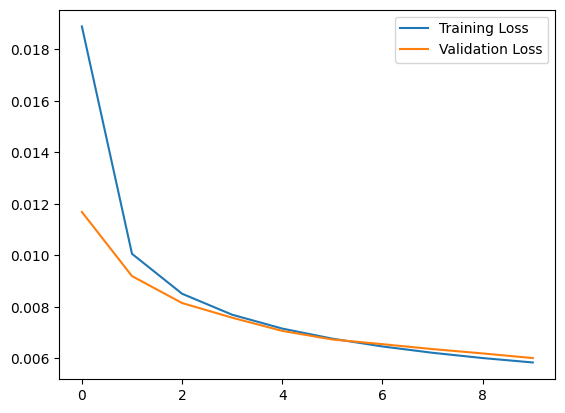

In [5]:
# Train the model
history = autoencoder.fit(x_train, x_train, epochs=10, validation_data=(x_val, x_val))

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Optimize your model

Model: "autoencoder_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (1, 4, 4, 32)          │        37,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (1, 28, 28, 1)         │        46,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,777 (327.25 KB)

 Trainable params: 83,777 (327.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 0.0232 - val_loss: 0.0088
Epoch 2/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 3/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 4/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 5/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 6/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 7/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 8/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 9/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 10/10
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0051 - val_loss: 0.0051


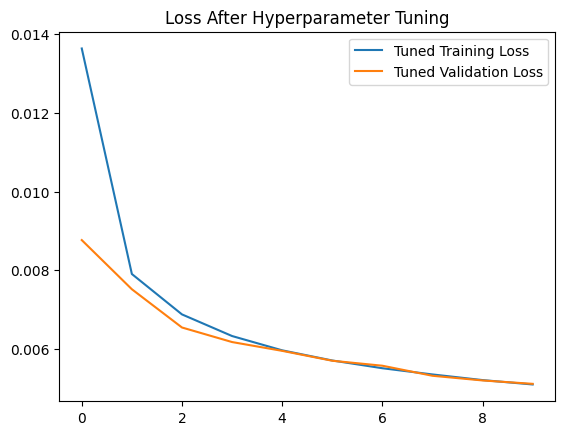

In [6]:
# Hyperparameters
learning_rate = 0.002 # Default is 0.001
batch_size = 16 # Default is 32

# Recompile the model with the tuned learning rate
autoencoder = create_autoencoder()
autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

# Retrain the model for another 10 epochs with the new batch size
history_tuned = autoencoder.fit(x_train, x_train, 
                                epochs=10, 
                                batch_size=batch_size, 
                                validation_data=(x_val, x_val))

# Plot the tuned model's training and validation loss

plt.plot(history_tuned.history['loss'], label='Tuned Training Loss')
plt.plot(history_tuned.history['val_loss'], label='Tuned Validation Loss')
plt.legend()
plt.title("Loss After Hyperparameter Tuning")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


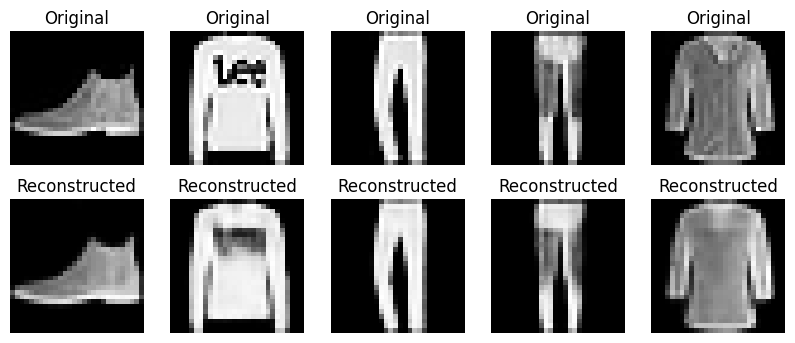

In [7]:
# Display some reconstructed images
def display_reconstructions(model, data, n=5):
    reconstructions = model.predict(data[:n])
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

# Test and display reconstructed samples
display_reconstructions(autoencoder, x_test)

### Decrease the latent space


Training with latent space feature dimension: 32


Model: "autoencoder_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (1, 4, 4, 32)          │        37,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (1, 28, 28, 1)         │        46,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,777 (327.25 KB)

 Trainable params: 83,777 (327.25 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


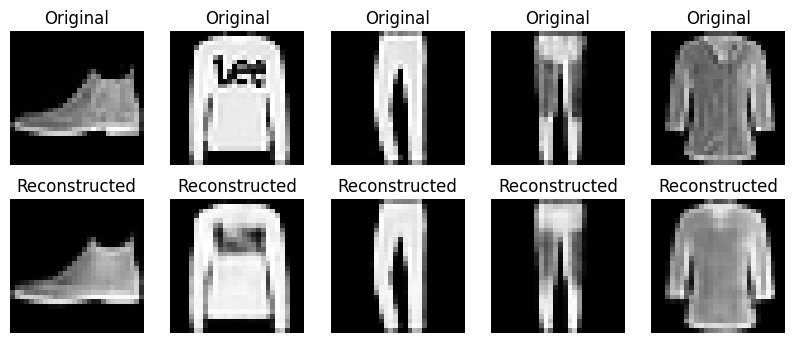


Training with latent space feature dimension: 28


Model: "autoencoder_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (1, 4, 4, 28)          │        34,972 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (1, 28, 28, 1)         │        42,029 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,001 (300.79 KB)

 Trainable params: 77,001 (300.79 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


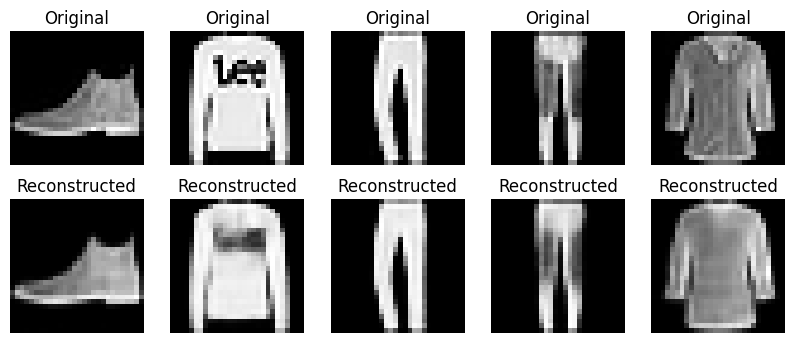


Training with latent space feature dimension: 24


Model: "autoencoder_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (1, 4, 4, 24)          │        32,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_9 (Sequential)       │ (1, 28, 28, 1)         │        37,849 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,513 (275.44 KB)

 Trainable params: 70,513 (275.44 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


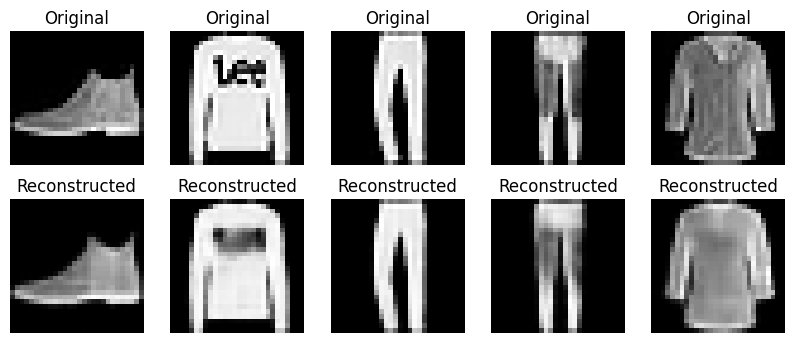


Training with latent space feature dimension: 20


Model: "autoencoder_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_10 (Sequential)      │ (1, 4, 4, 20)          │        30,356 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_11 (Sequential)      │ (1, 28, 28, 1)         │        33,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,313 (251.22 KB)

 Trainable params: 64,313 (251.22 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


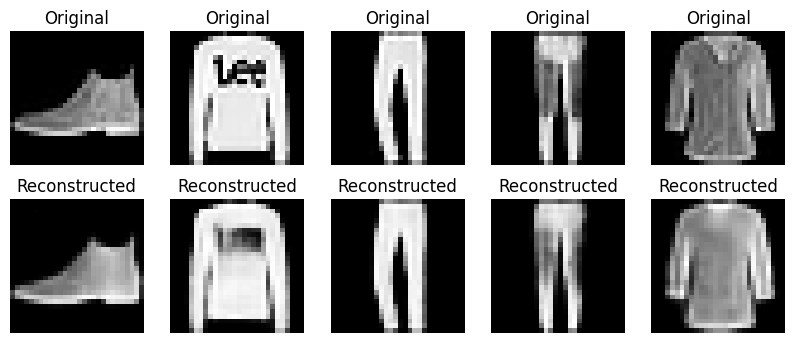


Training with latent space feature dimension: 16


Model: "autoencoder_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (1, 4, 4, 16)          │        28,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_13 (Sequential)      │ (1, 28, 28, 1)         │        30,353 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,401 (228.13 KB)

 Trainable params: 58,401 (228.13 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


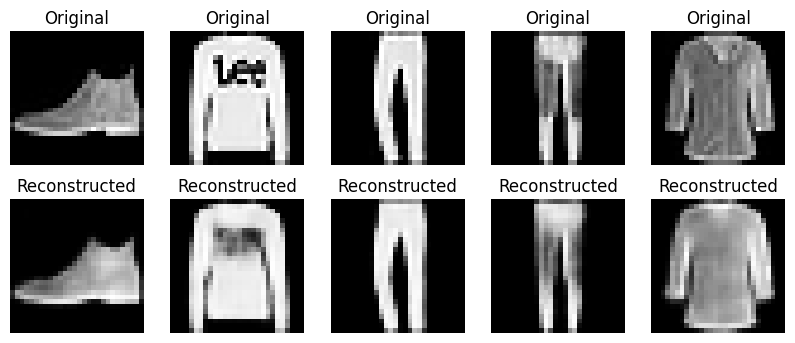


Training with latent space feature dimension: 12


Model: "autoencoder_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_14 (Sequential)      │ (1, 4, 4, 12)          │        25,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_15 (Sequential)      │ (1, 28, 28, 1)         │        27,037 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,777 (206.16 KB)

 Trainable params: 52,777 (206.16 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


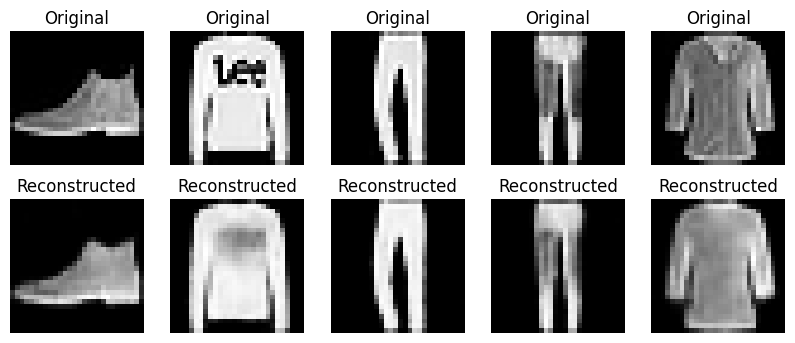


Training with latent space feature dimension: 8


Model: "autoencoder_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_16 (Sequential)      │ (1, 4, 4, 8)           │        23,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_17 (Sequential)      │ (1, 28, 28, 1)         │        24,009 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,441 (185.32 KB)

 Trainable params: 47,441 (185.32 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


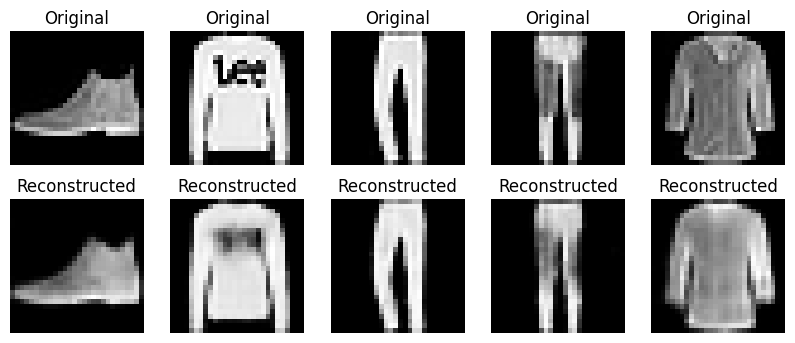

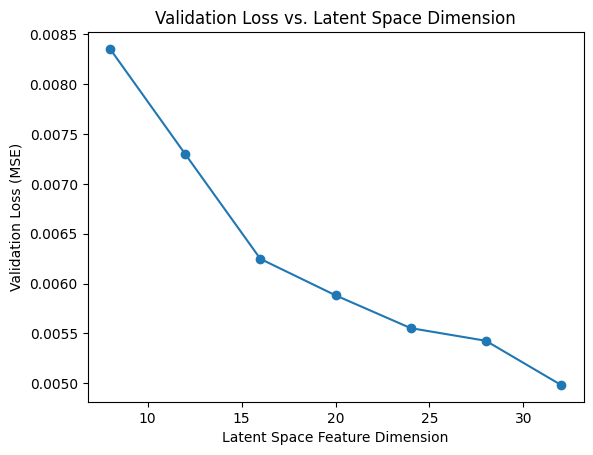

In [8]:
initial_latent_features = 32
latent_losses = []

# Select 5 fixed samples for all models
fixed_samples = x_test[:5]

# Decrease latent space by 4 each iteration and retrain model
for features in range(initial_latent_features, 4, -4):
    print(f"\nTraining with latent space feature dimension: {features}")
    autoencoder = create_autoencoder(latent_dim=(4, 4, features))
    autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())
    
    # Train and record validation performance
    history = autoencoder.fit(x_train, x_train, 
                              epochs=10, 
                              batch_size=batch_size, 
                              validation_data=(x_val, x_val), 
                              verbose=0)  # Set verbose to 0 to reduce output clutter
    
    # Append the last validation loss for this latent space size
    val_loss = history.history['val_loss'][-1]
    latent_losses.append((features, val_loss))

    # Display reconstructions using fixed samples
    display_reconstructions(autoencoder, fixed_samples, n=5)

# Plot the recorded validation losses
latent_dims, val_losses = zip(*latent_losses)
plt.plot(latent_dims, val_losses, marker='o')
plt.xlabel("Latent Space Feature Dimension")
plt.ylabel("Validation Loss (MSE)")
plt.title("Validation Loss vs. Latent Space Dimension")
plt.show()

### Final training


Training final model with optimal latent space dimension: 32


Model: "autoencoder_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_18 (Sequential)      │ (1, 4, 4, 32)          │        37,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_19 (Sequential)      │ (1, 28, 28, 1)         │        46,497 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,777 (327.25 KB)

 Trainable params: 83,777 (327.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0235 - val_loss: 0.0087
Epoch 2/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0083 - val_loss: 0.0075
Epoch 3/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 4/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 5/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0060 - val_loss: 0.0061
Epoch 6/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 7/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 8/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 0.0054 - val_loss: 0.0054
Epoch 9/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 0.0052 - val_loss: 0.0052
Epoch 10/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 11/30
3375/3375 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 12/30
3375/33

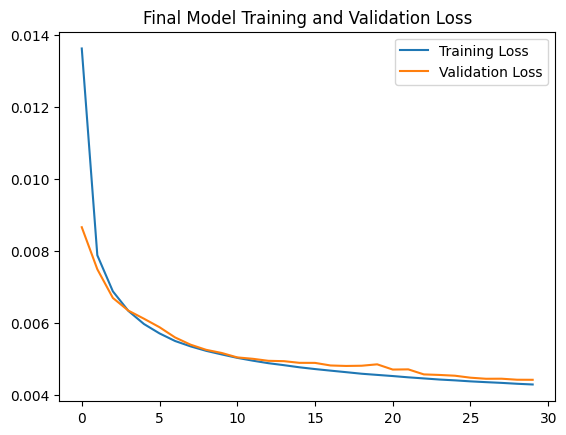

Model weights saved as 'model/optimal_autoencoder.weights.h5'


In [9]:
optimal_latent_dim = min(latent_dims, key=lambda x: val_losses[latent_dims.index(x)] if val_losses[latent_dims.index(x)] < 0.1 else float('inf'))

# Rebuild and train the autoencoder with the optimal latent space dimension
print(f"\nTraining final model with optimal latent space dimension: {optimal_latent_dim}")

final_autoencoder = create_autoencoder(latent_dim=(4, 4, optimal_latent_dim))
final_autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

# Train the model for 30 epochs on the full training set
history_final = final_autoencoder.fit(x_train, x_train, 
                                      epochs=30, 
                                      batch_size=batch_size, 
                                      validation_data=(x_val, x_val))

# Plot training and validation loss for the final model
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Final Model Training and Validation Loss")
plt.show()

# Save the final model weights
final_autoencoder.save_weights("model/optimal_autoencoder.weights.h5")

print("Model weights saved as 'model/optimal_autoencoder.weights.h5'")

### Testing the autoencoder

In [10]:
final_autoencoder.save("model/optimal_autoencoder.h5")

Final Model Reconstruction Error (MSE) on Test Dataset: 0.0044
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


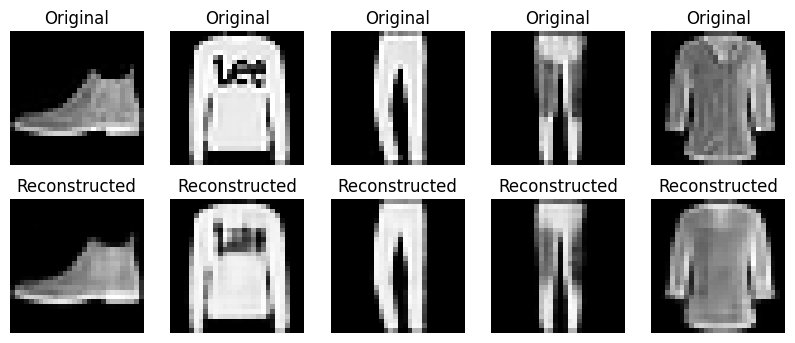

In [11]:
# Evaluate the final model on the test dataset to get the reconstruction error score
test_loss = final_autoencoder.evaluate(x_test, x_test, verbose=0)
print(f"Final Model Reconstruction Error (MSE) on Test Dataset: {test_loss:.4f}")

# Test the model on the test dataset and visualize reconstructions
display_reconstructions(final_autoencoder, x_test, n=5)